Présentation du projet : ...

In [13]:
import platform
from pathlib import Path

import matplotlib.pyplot as plt # pour la visualisation
import numpy as np # pour les opérations mathématiques 
import pandas as pd # pour la manipulation de données 
import seaborn as sns # pour la visualisation
import sklearn # pour les outils d'apprentissage automatique
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    accuracy_score,
)

Tout d'abord nous allons machin machin

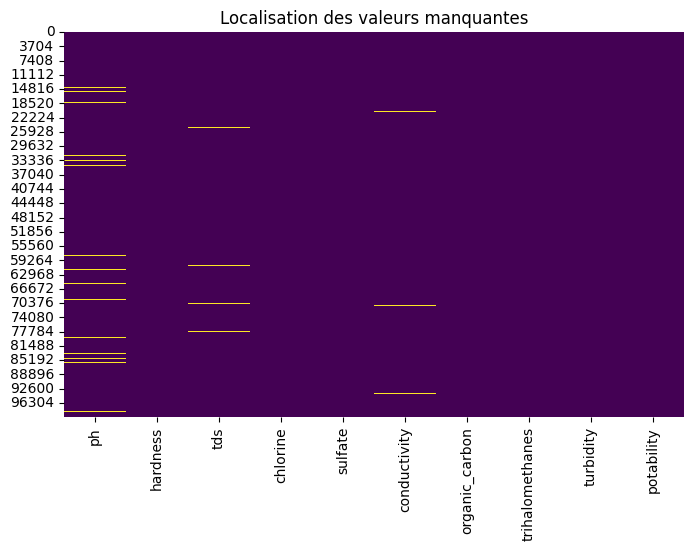

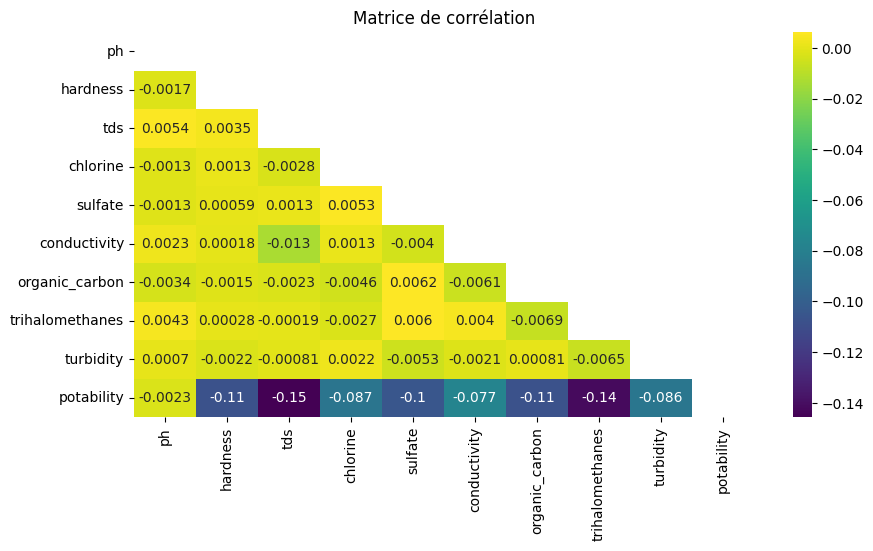

In [14]:
############# Préprocessing #############

# Lecture du fichier
data = pd.read_csv('Data/Watera.csv')

# Visualisation des valeurs manquantes
plt.figure(figsize=(8, 5))
sns.heatmap(data.isna(), cbar=False, cmap="viridis")
plt.title("Localisation des valeurs manquantes")
plt.show()

# Suppression des lignes contenant des NaN
data.dropna(axis="index", inplace=True)
data.reset_index(drop=True, inplace=True)

# Vérification des corrélations
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(data.corr(numeric_only=True), dtype=bool))
sns.heatmap(
    data.corr(numeric_only=True),
    cbar=True,
    annot=True,
    cmap="viridis",
    mask=mask,
)
plt.title("Matrice de corrélation")
plt.show()

Ensuite blablablabla

In [15]:
############# Division des données #############

# Séparation des variables explicatives et cible
X = data.drop('potability', axis=1)
y = data['potability']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [16]:
# Initialisation des modèles
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}

# Entraînement et évaluation de chaque modèle
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    acc = accuracy_score(y_test, y_pred)
    results[name] = {"model": model, "auc": auc, "accuracy": acc}
    print(f"{name} - AUC: {auc:.3f} | Accuracy: {acc:.3f}")

# Sélection du meilleur modèle
best_model_name = max(results, key=lambda x: results[x]["auc"])
best_model = results[best_model_name]["model"]
print(f"\nMeilleur modèle : {best_model_name} avec AUC = {results[best_model_name]['auc']:.3f}")

Logistic Regression - AUC: 0.887 | Accuracy: 0.922
Random Forest - AUC: 1.000 | Accuracy: 1.000
Decision Tree - AUC: 0.999 | Accuracy: 1.000
K-Nearest Neighbors - AUC: 0.921 | Accuracy: 0.938

Meilleur modèle : Random Forest avec AUC = 1.000



Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17059
           1       1.00      1.00      1.00      1401

    accuracy                           1.00     18460
   macro avg       1.00      1.00      1.00     18460
weighted avg       1.00      1.00      1.00     18460



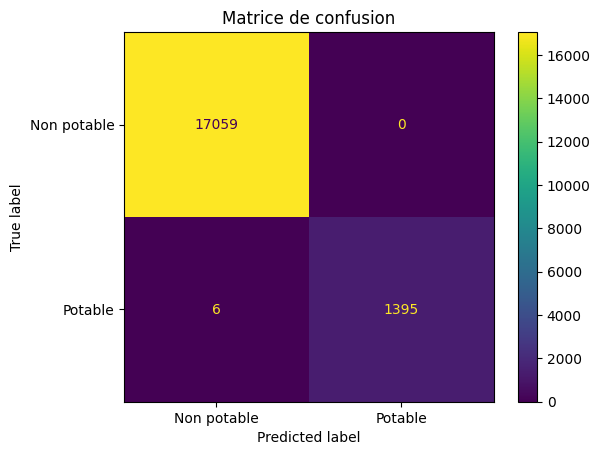

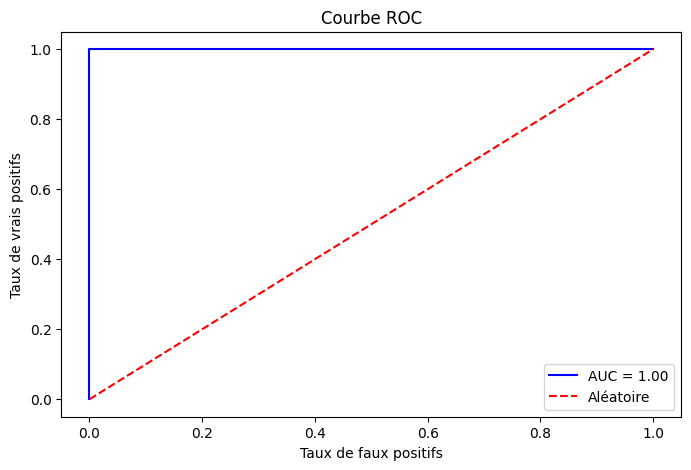

In [17]:
############# Analyse approfondie des performances #############

# Prédictions finales
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Rapport de classification
print("\nRapport de classification :\n", classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non potable", "Potable"])
disp.plot(cmap="viridis")
plt.title("Matrice de confusion")
plt.show()

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='b', label=f"AUC = {results[best_model_name]['auc']:.2f}")
plt.plot([0, 1], [0, 1], 'r--', label="Aléatoire")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()